# BCI Interactive Notebook

Now, let's have  first look at EEG data. First, of course, we'll have to take care of what python libraries we will need - we've taken care of most of it for you.

## Settings

Run the following cells to import what you need - this may take a while, and please let us know if you come up against some probelms here.


In [1]:
! pip install pymatreader

In [2]:
!  pip install mne

In [3]:
import os
import numpy as np
import mne
import pymatreader
%matplotlib inline
from scipy.io import loadmat 
import mne, glob 
from numpy import loadtxt
from pymatreader import read_mat
from pylab import rcParams

## Building converted dataset

Great! Everything is now set up so that we can start - let's first import the data from drive (or you can also download it locally if you prefer, but we recommend the google colab & drive option).


In [4]:
mat_data = read_mat('testData.mat')

# let's print what it looks like...
mat_data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Jul 21 17:16:15 2020',
 '__version__': '1.0',
 '__globals__': [],
 'testData': array([[[  2.13698602,   1.21478415, -20.81404305, ...,  -1.25696659,
           18.22851944, -14.06232452],
         [ -0.07878079,   3.2615397 , -18.78509521, ...,  -3.47843122,
           15.25557518, -17.40423393],
         [ -2.39545727,   4.27259254, -13.47355747, ...,  -5.47515154,
           11.27915287, -19.85143089],
         ...,
         [ -9.90622997,  20.31794548,   8.57473946, ..., -16.28536034,
           -9.76611996,  -8.29433727],
         [ -8.33884621,  16.53199577,   8.45297623, ..., -18.15717888,
          -16.17450142, -10.37259769],
         [ -5.97048616,  12.82243824,   7.66735363, ..., -17.40464592,
          -22.85551071, -11.4784832 ]],
 
        [[  7.70674562,   0.34019905, -22.86667442, ...,   6.40166903,
           10.75745392, -18.36013603],
         [  8.39195824,  -0.69046164, -20.97916794, ...,   3.9

This may look a bit confusing - but luckily we can see that there's a header for "test data" This is what we need.

In [5]:
# The format here is 8 channels  x 350 epochs x 2400 steps
X = mat_data['testData']
print(X.shape)

(8, 350, 2400)


In [6]:
# let's have a look at what the data looks like - a bunch of numbers, they don't mean much to us yet
print(X[:2,:5])

[[[  2.13698602   1.21478415 -20.81404305 ...  -1.25696659  18.22851944
   -14.06232452]
  [ -0.07878079   3.2615397  -18.78509521 ...  -3.47843122  15.25557518
   -17.40423393]
  [ -2.39545727   4.27259254 -13.47355747 ...  -5.47515154  11.27915287
   -19.85143089]
  [ -4.8140974    4.15460348  -6.83620167 ...  -6.6113615    7.00976086
   -19.91583824]
  [ -7.00420523   2.95736074  -0.69164068 ...  -6.51472473   3.05451918
   -16.94121361]]

 [[  7.70674562   0.34019905 -22.86667442 ...   6.40166903  10.75745392
   -18.36013603]
  [  8.39195824  -0.69046164 -20.97916794 ...   3.91781378   7.63641882
   -21.11932755]
  [  7.82593918  -1.87710583 -16.27248573 ...   1.0227828    4.91969872
   -22.98224831]
  [  5.86383486  -3.10288978 -10.38068485 ...  -1.17095459   3.12452483
   -22.55347443]
  [  3.01075053  -4.17344713  -4.76299334 ...  -1.91760993   2.35487533
   -19.32350731]]]


In [7]:
# we change the data around a bit
data = np.rollaxis(X, 2, 0)  
data.shape

(2400, 8, 350)

In [8]:
# let's get data on what actually happened during the EEG experiment - the events & labels
labels0=('testLabels.txt')
events0=('testEvents.txt')
targets0=('testTargets.txt')

labels = loadtxt(labels0)

events = loadtxt(events0)

targets = loadtxt(targets0)

In [9]:
# we print the shapes
print(labels.shape,events.shape,targets.shape)

(50,) (2400,) (2400,)


In [10]:
# these are the names of the different channels - the electrode sensors which are placed on the head
chan_names = ['C3', 'Cz', 'C4', 'CPz','P3', 'Pz', 'P4', 'POz'] 

In [11]:
# let's make a dictionary so it's easier to figure out what all the events are
# they represent different objects the subjects saw during the experiment.
event_dict = dict( books=1, radio=2, printer=3, laptop=4, ball=5, corkboard=6, wooden_plane=7, picture=8)
sfreq = 250 # this is the sampling frequency

In [12]:
"""We need the following information to create MNE structure:
    data ([ndarray]): [trials x chans x samples]
    y ([ndarray]):    [class label array  [1, labels]]
    sfreq ([int]):    [sampling frequency]
    event_id ([dict]): [{1 :'pos', -1 : 'neg'} - class labels id]
    chan_names ([list]): [channel names in a list of strings]
"""                     

n_channels = len(data[1,:,1]) # extract the number of channels (it's 8, but let's get it straight from the data)

# Initialize an info structure
info = mne.create_info(
        ch_names = chan_names,
        ch_types = ['eeg']*n_channels,
        sfreq    = sfreq 
        )   

info.set_montage('standard_1020')
print('Event created :', info) 

Event created : <Info | 8 non-empty values
 bads: []
 ch_names: C3, Cz, C4, CPz, P3, Pz, P4, POz
 chs: 8 EEG
 custom_ref_applied: False
 dig: 11 items (3 Cardinal, 8 EEG)
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 8
 projs: []
 sfreq: 250.0 Hz
>


In [13]:
# Create an event matrix: events with alternating event codes
eventLength = events.shape[0]
ev = [i*sfreq*0.300 for i in range(eventLength)]
# let's have a look at what it looks like
print(ev[:100])

[0.0, 75.0, 150.0, 225.0, 300.0, 375.0, 450.0, 525.0, 600.0, 675.0, 750.0, 825.0, 900.0, 975.0, 1050.0, 1125.0, 1200.0, 1275.0, 1350.0, 1425.0, 1500.0, 1575.0, 1650.0, 1725.0, 1800.0, 1875.0, 1950.0, 2025.0, 2100.0, 2175.0, 2250.0, 2325.0, 2400.0, 2475.0, 2550.0, 2625.0, 2700.0, 2775.0, 2850.0, 2925.0, 3000.0, 3075.0, 3150.0, 3225.0, 3300.0, 3375.0, 3450.0, 3525.0, 3600.0, 3675.0, 3750.0, 3825.0, 3900.0, 3975.0, 4050.0, 4125.0, 4200.0, 4275.0, 4350.0, 4425.0, 4500.0, 4575.0, 4650.0, 4725.0, 4800.0, 4875.0, 4950.0, 5025.0, 5100.0, 5175.0, 5250.0, 5325.0, 5400.0, 5475.0, 5550.0, 5625.0, 5700.0, 5775.0, 5850.0, 5925.0, 6000.0, 6075.0, 6150.0, 6225.0, 6300.0, 6375.0, 6450.0, 6525.0, 6600.0, 6675.0, 6750.0, 6825.0, 6900.0, 6975.0, 7050.0, 7125.0, 7200.0, 7275.0, 7350.0, 7425.0]


In [14]:
# let's now put them together into an array - makes it easier to wark with
events1 = np.column_stack((np.array(ev),
                          np.array(targets),
                          np.array(events)))

print(events1, events1.shape, events1.dtype)

# we want the events to be set to integers
events1=events1.astype(np.int64)

[[0.00000e+00 0.00000e+00 5.00000e+00]
 [7.50000e+01 0.00000e+00 2.00000e+00]
 [1.50000e+02 0.00000e+00 6.00000e+00]
 ...
 [1.79775e+05 0.00000e+00 1.00000e+00]
 [1.79850e+05 1.00000e+00 7.00000e+00]
 [1.79925e+05 0.00000e+00 3.00000e+00]] (2400, 3) float64


In [15]:
print(events1)

[[     0      0      5]
 [    75      0      2]
 [   150      0      6]
 ...
 [179775      0      1]
 [179850      1      7]
 [179925      0      3]]


## Plotting

Now, to the actual fun part! Let's start plotting the data.


In [16]:
# we wwant to look at the data 200 ms before the stimulus (objects such as book etc that we made a dict for before)
tmin = -0.200                
# Create the :class:`mne.EpochsArray` object - don't worry too much about it
epochs = mne.EpochsArray(data, info, events1, tmin, event_dict)

Not setting metadata
Not setting metadata
2400 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


In [17]:
# we set some parameters for plotting
rcParams['figure.figsize'] = 5, 7

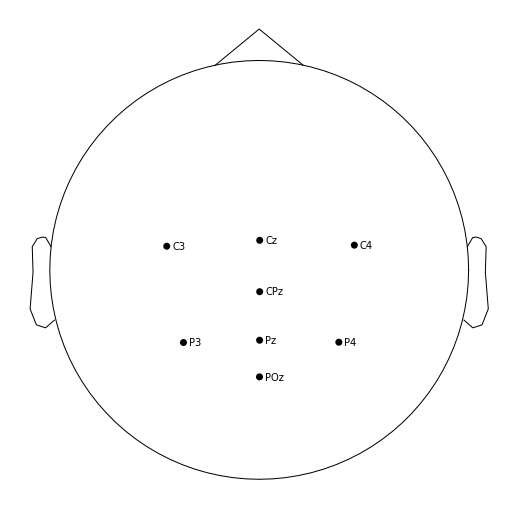

Figure(504x504)


In [18]:
# this will let us see where the sensors where placed - very handy since we didn't collect the data ourselves.
print(epochs.plot_sensors(show_names=True))

# "C" here means central and "P" means parietal.

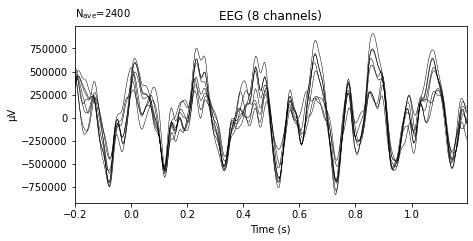

In [19]:
# quick visualization  - we just get the average of the epochs
epochs.average().plot();

Not setting metadata
Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "gfp"


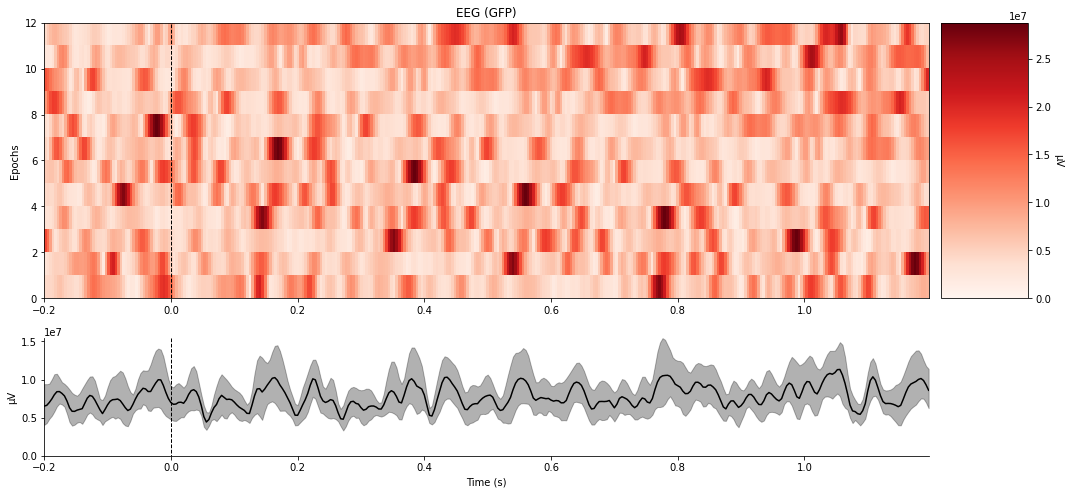

[<Figure size 1080x504 with 3 Axes>]

In [20]:
# let's plot the epochs slightly differently - each trial is one row in the plot
rcParams['figure.figsize'] = 15, 7
epochs[0:12].plot_image()

    Using multitaper spectrum estimation with 7 DPSS windows


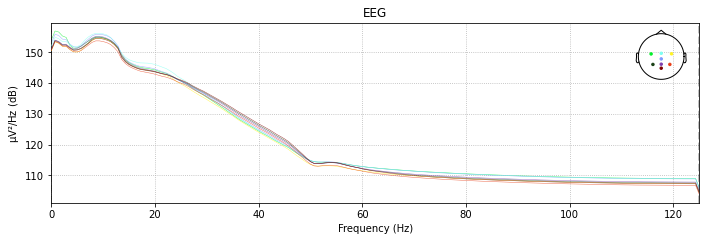

In [21]:
# now we plot the spectral density across channels - how much of each frequency is there?
epochs.plot_psd();

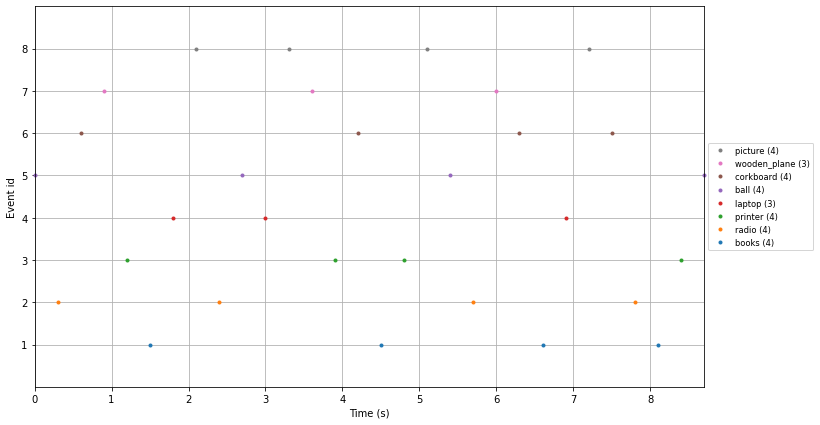

In [22]:
# now we just plot the different events as they happen over time in the experiment data
fig = mne.viz.plot_events(events1[0:30],sfreq,event_id=event_dict)

Fitting ICA to data using 8 channels (please be patient, this may take a while)


/Users/ronja/opt/anaconda3/lib/python3.8/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/Users/ronja/opt/anaconda3/lib/python3.8/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/var/folders/k3/vwjmrq0520q77y4k8lkds2b80000gn/T/ipykernel_1605/3652944886.py:6: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(epochs) # we simply fit the epochs to the ICA model - very handy


Selecting by number: 8 components
Fitting ICA took 8.4s.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata


/Users/ronja/opt/anaconda3/lib/python3.8/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/Users/ronja/opt/anaconda3/lib/python3.8/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


Not setting metadata
2400 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
2400 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


/Users/ronja/opt/anaconda3/lib/python3.8/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/Users/ronja/opt/anaconda3/lib/python3.8/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


Not setting metadata
Not setting metadata
2400 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


/Users/ronja/opt/anaconda3/lib/python3.8/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/Users/ronja/opt/anaconda3/lib/python3.8/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


Not setting metadata
Not setting metadata
2400 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


/Users/ronja/opt/anaconda3/lib/python3.8/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/Users/ronja/opt/anaconda3/lib/python3.8/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


Not setting metadata
Not setting metadata
2400 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


/Users/ronja/opt/anaconda3/lib/python3.8/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/Users/ronja/opt/anaconda3/lib/python3.8/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


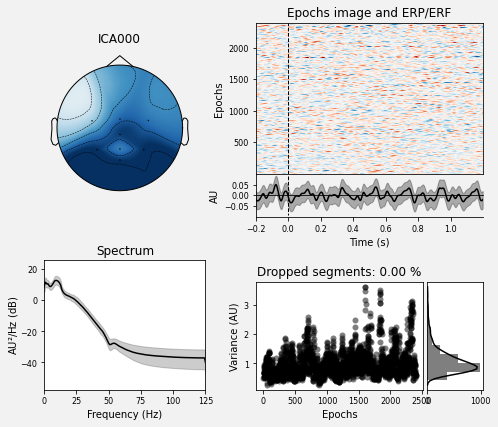

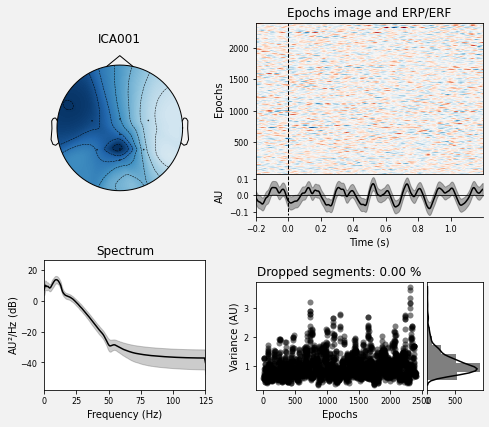

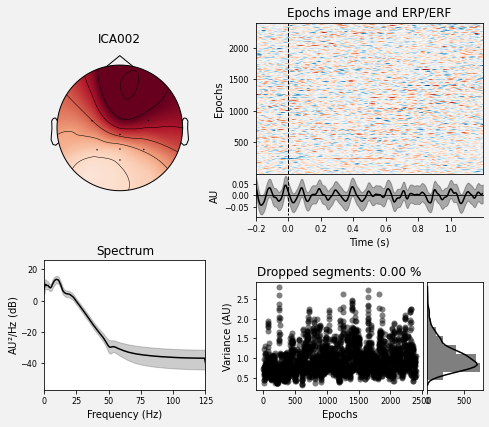

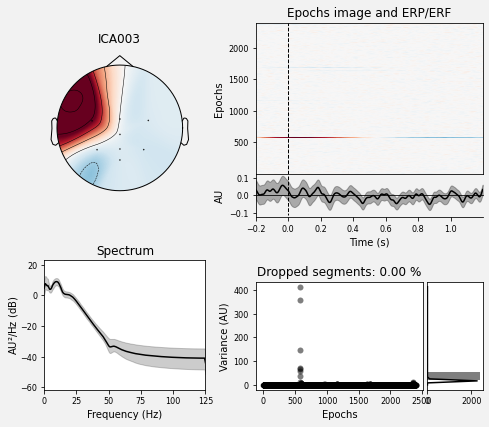

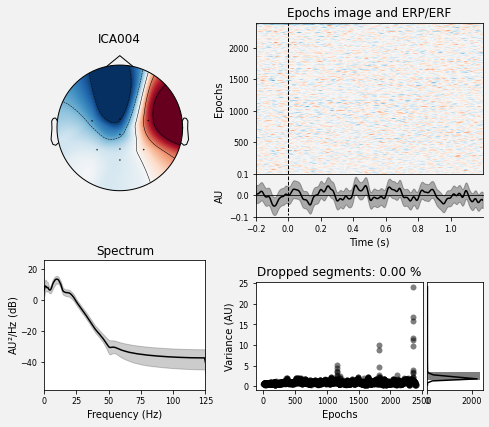

[<Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>]

In [23]:
# let's filter it a bit - we remove some frequencies that we know cant have come from the brain and are thus noise
# filtered_epochs = mne.filter.filter_data(epochs,sfreq,1,40) # for this, we won't use it

# now, we do ICA - it extracts important components and will let us filter out noise ("artifacts" such as blinking)
ica = mne.preprocessing.ICA(n_components=8, random_state=97, max_iter=800)
ica.fit(epochs) # we simply fit the epochs to the ICA model - very handy
#ica.exclude = [1, 2]  # details on how we picked these are omitted here
#ica.plot_properties(epochs, picks=ica.exclude)

ica.plot_properties(epochs)

# this may take a while...

Great, we've gotten some very nice graphs - we can see some major components of the brain activity. This can be used to filter out eye blinking! If we see that one of the ICA00X components seem to be centered mostly around the eyes, we can exclude those directly.

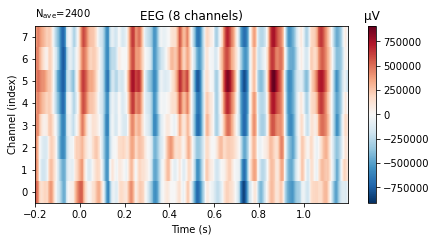

Figure(460.8x216)


In [24]:
# as a final plot, let's just look at the average electrical activations of the 8 channels
print(epochs.average().plot_image())

# Interactive Section 1

Here, we will start experimenting a bit with the data. We'll plot the eeg data for each different stimulus - the books, the laptops, balls etc. Let's first remind ourselves what our data looks like.

In [25]:
# we have the dictionary of the different "events" - the different objects looked at.
event_dict['ball']

5

### Mini Exercise

books  :  1


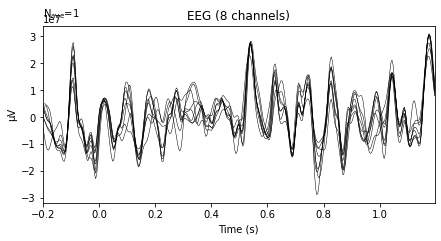

radio  :  2


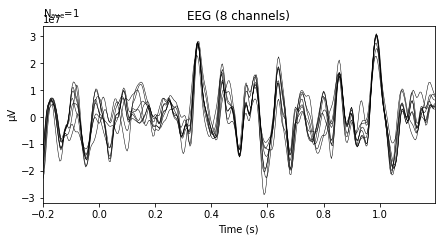

printer  :  3


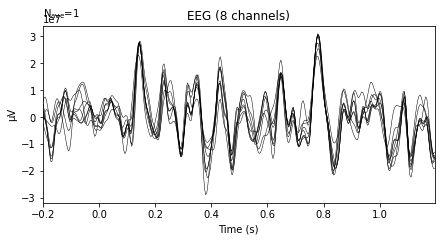

laptop  :  4


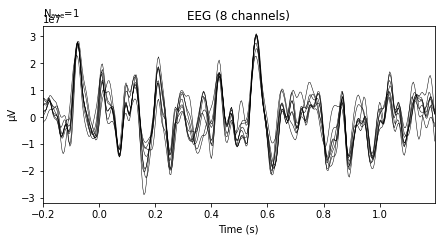

ball  :  5


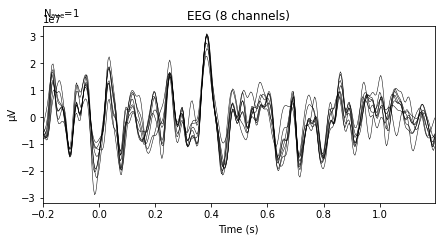

corkboard  :  6


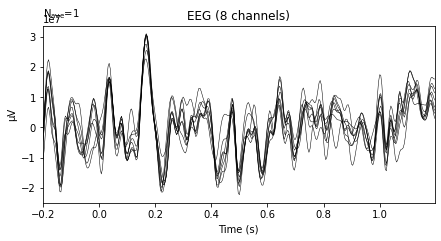

wooden_plane  :  7


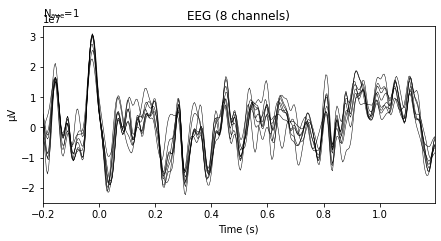

picture  :  8


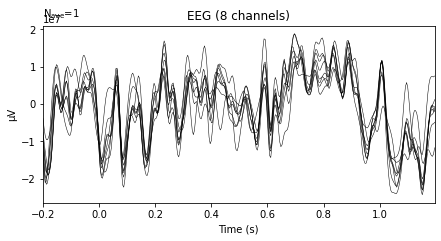

In [26]:
# for each object, let's plot what the response to seeing that object looks like in average across ALL trials
for i in event_dict:
    print("This is the obejct I'm looking at...")
    obj_index = # fill in the text name for each object per number, so, use the event_dict to convert 1 to "ball" etc.
    epochs[obj_index].average().plot()


Alright, nice! We've seen that they look a bit different. In the experiment however, it wasn't all just about the events. They also checked whether or not each object was the "target" - an object that the subject was asked to look at/paid attention to specifically.

# Interactive Section  2

Now, we look at whether an object was paid attention to, regardless of what kind of object this was. We want to distinguish between target and non-target EEG responses.

In [27]:
# let's get the data
eventLength = events.shape[0]
ev = [i*sfreq*0.300 for i in range(eventLength)]

In [28]:
# we put it in a new array and change it to integer
events2 = np.column_stack((np.array(ev),
                          np.zeros(eventLength,  dtype = int),
                          np.array(targets)))

events2=events2.astype(np.int64)

In [29]:
# comparing to events 1 (previous section with the objects, we now only have values of 0 and 1 
# in the column- nontarget or target. 
print(events2) 

[[     0      0      0]
 [    75      0      0]
 [   150      0      0]
 ...
 [179775      0      0]
 [179850      0      1]
 [179925      0      0]]


Alright, we have the data, let's now prepare it to look at target vs non-target.

In [30]:
target_dict = dict( no=0,si=1) # let's make a dict of target (si) or non-target (no)

In [31]:
# let's put it in a nice array
target_epochs = mne.EpochsArray(data, info, events2, tmin, event_id=target_dict)

Not setting metadata
Not setting metadata
2400 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


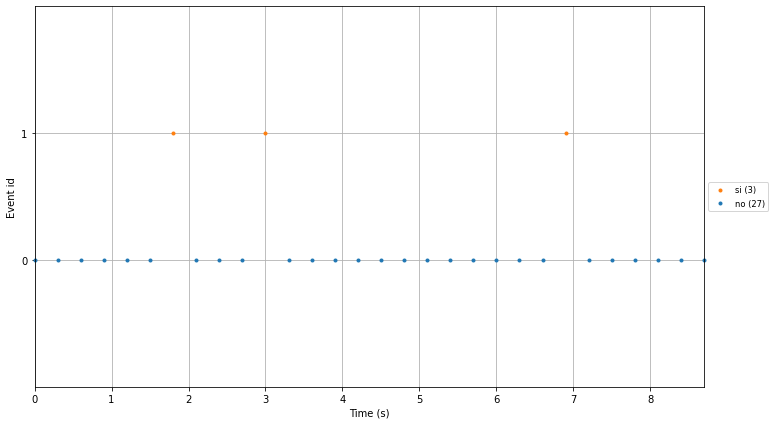

In [32]:
# and now, we visualize!
fig = mne.viz.plot_events(events2[0:30],sfreq, event_id=target_dict)

no


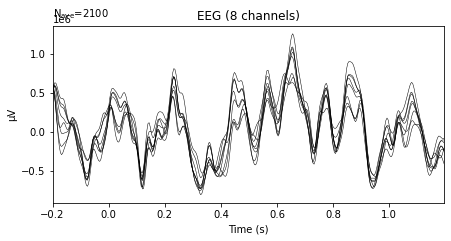

si


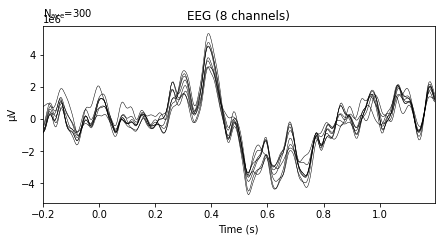

Figure(460.8x216)


In [33]:
print('no')
target_epochs['no'].average().plot()
print('si')
print(target_epochs['si'].average().plot())

Target - si
Not setting metadata
Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "gfp"


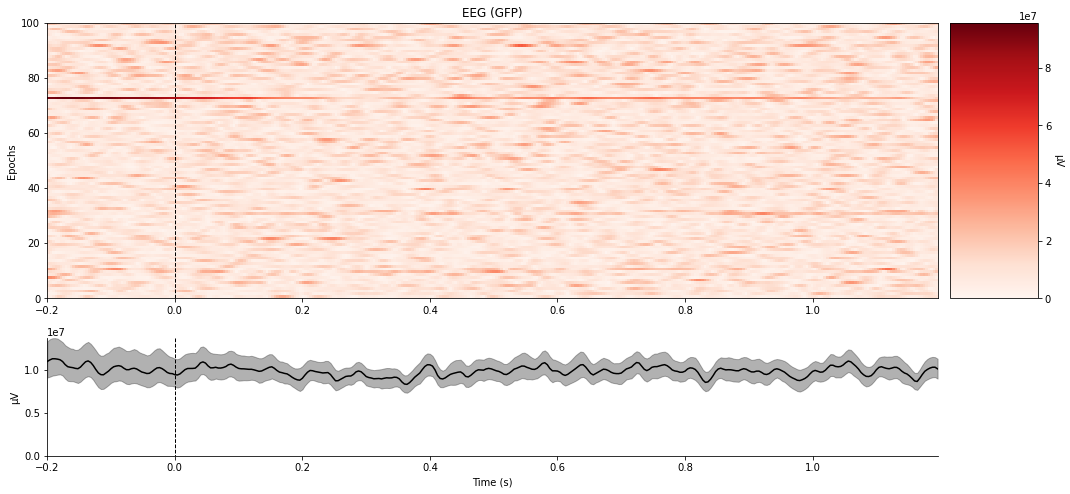

Non-Target - no
Not setting metadata
Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "gfp"


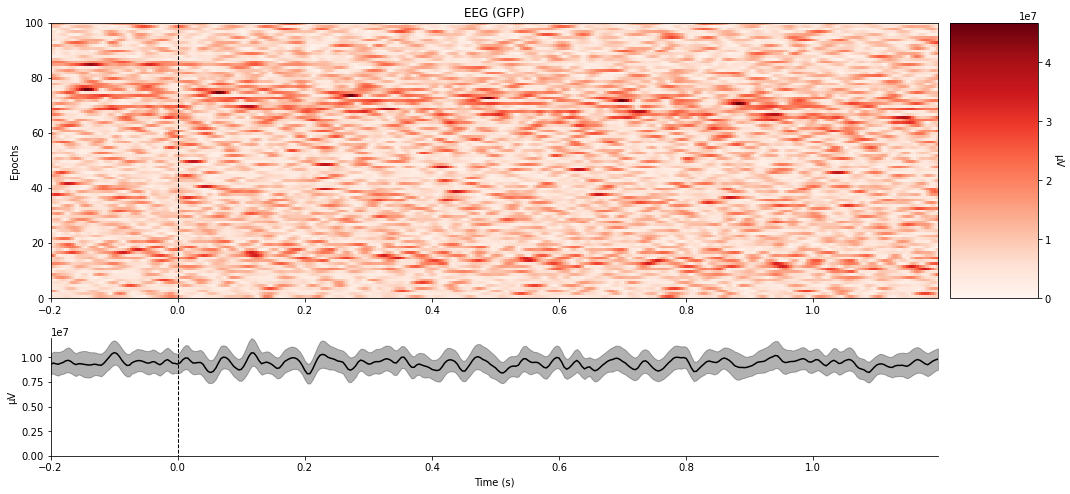

[<Figure size 1080x504 with 3 Axes>]

In [34]:
# now let's plot what it looks like in target events versus non-target events more closely in a subset
print("Target - si")
target_epochs['si'][0:100].plot_image()
print("Non-Target - no")
target_epochs['no'][0:100].plot_image()

## Interactive Section 3

Now, we can make it a bit more specific - let's plot the eeg data, dividing them for each object and whether the object was the target or not. This way, we can see, specifically, how the brain reacts to seeing a book as a target or a non-target.


In [35]:
# let's again get the labels, events and targets
labels1=('/content/testLabels.txt')
events1=('/content/testEvents.txt')
targets1=('/content/testTargets.txt')

labels = loadtxt(labels0)

events = loadtxt(events0)

targets = loadtxt(targets0)

In [36]:
eventLength = events.shape[0]
ev = [i*sfreq*0.300 for i in range(eventLength)]

In [37]:
# we again put it in a nice array again and change it to integers
events3 = np.column_stack((np.array(ev),
                          np.array(targets),
                          np.array(events)))

events3=events3.astype(np.int64)

In [38]:
print(events3)

[[     0      0      5]
 [    75      0      2]
 [   150      0      6]
 ...
 [179775      0      1]
 [179850      1      7]
 [179925      0      3]]


In [39]:
# we change the data a bit - we pick epochs of ball-stimulus only
for i in range(2400):
    if events3[i][1]==np.array([1]) and events3[i][2]==np.array([1]): # the 1 here represents the "ball" objects' ID
        events3[i][1:3]=[0,1]
    else:
        events3[i][1:3]=[0,0]
print(events3)

[[     0      0      0]
 [    75      0      0]
 [   150      0      0]
 ...
 [179775      0      0]
 [179850      0      0]
 [179925      0      0]]


In [40]:
# again, we set it to check 200ms before the stimulus onset
tmin = -0.200               
# Create the :class:`mne.EpochsArray` object
ball_target_epochs = mne.EpochsArray(data, info, events3, tmin, event_id=target_dict)

Not setting metadata
Not setting metadata
2400 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


### Mini Exercise

si - ball
Not setting metadata
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "gfp"


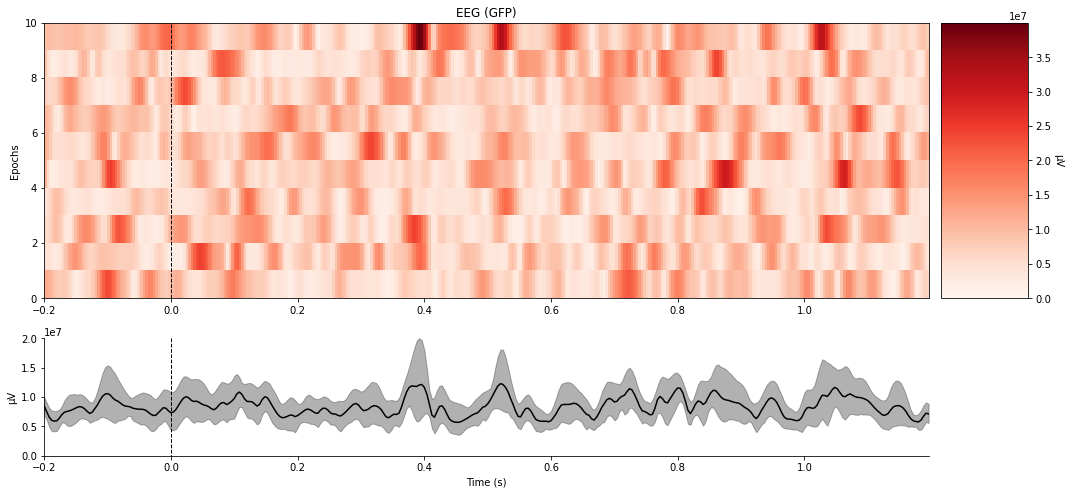

no - ball
Not setting metadata
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "gfp"


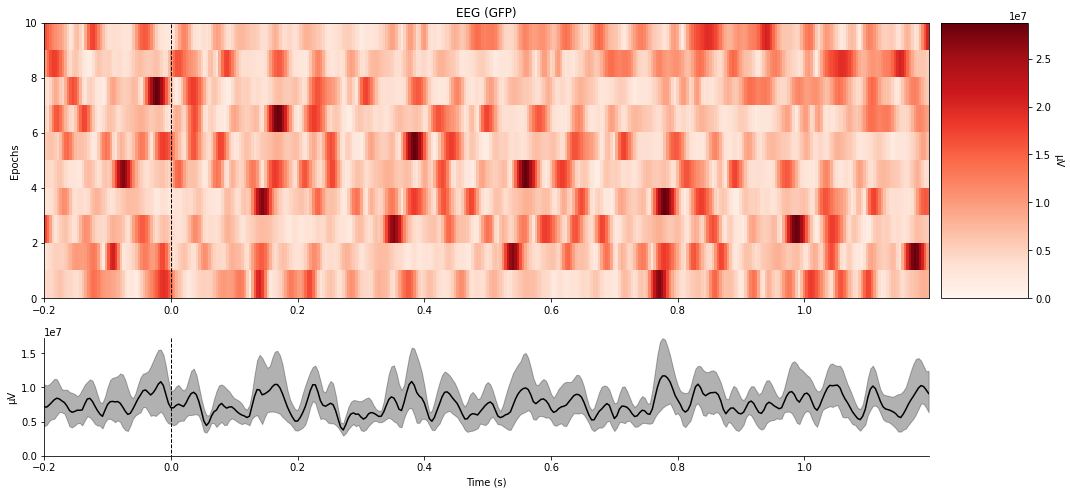

[<Figure size 1080x504 with 3 Axes>]

In [41]:
# now, we plot again
print("si - ball")
ball_target_epochs["insert class name"][0:10].plot_image() # feel free to play around with the range 0:10 here
print('no - ball')
ball_target_epochs["insert class name"][0:10].plot_image()

### Mini Exercise

no


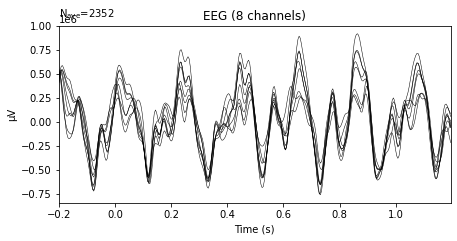

si


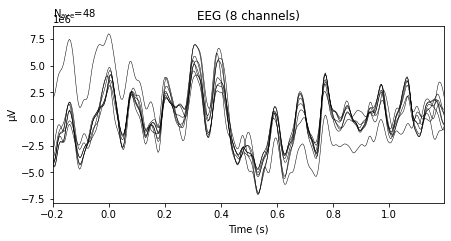

Figure(460.8x216)


In [42]:
print('no - ball')
ball_target_epochs["insert class name"].average().plot()
print('si - ball')
print(ball_target_epochs["insert class name"].average().plot())

Now, try this with books instead!